In [1]:
import pandas as pd

data1 = pd.read_csv('data3/P2_2A.csv', encoding='cp949')
data2 = pd.read_csv('data3/P2_2P.csv', encoding='cp949')
data3 = pd.read_csv('data3/P2_3A.csv', encoding='cp949')
data4 = pd.read_csv('data3/P2_3P.csv', encoding='cp949')
data5 = pd.read_csv('data3/P2_4A.csv', encoding='cp949')
data6 = pd.read_csv('data3/P2_4P.csv', encoding='cp949')
data7 = pd.read_csv('data3/P2_5A.csv', encoding='cp949')
data8 = pd.read_csv('data3/P2_5P.csv', encoding='cp949')
data9 = pd.read_csv('data3/P2_6A.csv', encoding='cp949')
data10 = pd.read_csv('data3/P2_6P.csv', encoding='cp949')

In [2]:
def filter_data(origin_data, columns):
    data = origin_data[columns]
    data = data[data["CGM(mg/dl)"] > 0]
    return data

common_var = ["CGM(mg/dl)", "LD1 Temp", "LD2 Temp", "LD3 Temp", "Rx1 Temp", "Rx2 Temp", "S1 Temp", "S2 Temp", "FR Mon", 
             "mPD1_dS", "mPD2_dS", "mPD3_dS", "T-rPD_L1dS", "T-rPD_L2dS", "T-rPD_L3dS", "R-rPD_L1dS", "R-rPD_L2dS", "R-rPD_L3dS"]

dataR1 = filter_data(data1, common_var)
dataR2 = filter_data(data2, common_var)
dataR3 = filter_data(data3, common_var)
dataR4 = filter_data(data4, common_var)
dataR5 = filter_data(data1, common_var)
dataR6 = filter_data(data2, common_var)
dataR7 = filter_data(data3, common_var)
dataR8 = filter_data(data4, common_var)
dataR9 = filter_data(data1, common_var)
dataR10 = filter_data(data2, common_var)

dataR = pd.concat([dataR1, dataR2, dataR3, dataR4, dataR5, dataR6, dataR7, dataR8, dataR9, dataR10])

print(len(dataR))

1468


In [3]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def preprocess(data , dt=False) -> tuple:
    if dt:
        data = data.astype({'CGM(mg/dl)':'int'})
    
    X = data.drop('CGM(mg/dl)', axis=1).values
    y = data['CGM(mg/dl)'].values
    y = y.round(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return torch.tensor(X_train, dtype=torch.float32), \
        torch.tensor(y_train, dtype=torch.float32), \
        torch.tensor(X_test, dtype=torch.float32), \
        torch.tensor(y_test, dtype=torch.float32)

dataR = preprocess(dataR, True)

C:\Users\ojski\anaconda3\envs\HnsEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from torch import onnx

def train_model(model, train_loader, num_epochs, learning_rate, name:str):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    epoch_losses = []
    for epoch in tqdm(range(num_epochs), desc=f'Train {name}'):
        total_loss = 0
        total_batches = 0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            with torch.set_grad_enabled(True):
                y_hat = model(X)
                loss = criterion(y_hat.squeeze(), y)
                total_loss += loss.item()
                total_batches += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss = total_loss / total_batches
        epoch_losses.append(epoch_loss)
    
    torch.save(model.state_dict(), f'property2/{name}.pt')
    onnx.export(model, X.to(device), f'property2/{name}.onnx')
    return epoch_losses

In [5]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 8
num_epochs = 100
learning_rate = 0.001

train_loaderR = DataLoader(TensorDataset(dataR[0].unsqueeze(1), dataR[1]), batch_size=batch_size, shuffle=True)

In [6]:
from model import MLP, Conv1DModel, LinearRegressionModel

model_conv = Conv1DModel(1, 2)
losses_conv1d = train_model(model_conv, train_loaderR, num_epochs, learning_rate, 'conv1d')

model_mlp = MLP(17)
losses_mlp = train_model(model_mlp, train_loaderR, num_epochs, learning_rate, 'mlp')

Train conv1d: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.83it/s]
C:\Work\CGM\ETRI_CGM_Analysis_ModelDev\JaeseongArea\model\_1d_conv_net.py:28: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  x = functional.avg_pool1d(x, kernel_size=int(x.size(dim=2)))
Train mlp: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.19it/s]


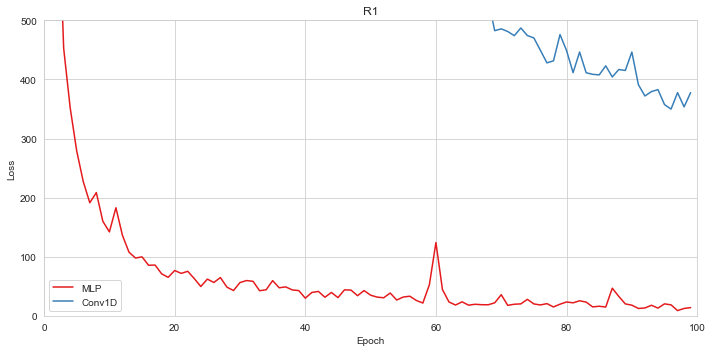

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_graph(ax, loss_mlp, loss_conv1d, title):
    ax.plot(loss_mlp, label='MLP')
    ax.plot(loss_conv1d, label='Conv1D')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.set_ylim(0, 500)
    ax.set_xlim(0, num_epochs)

    
sns.set_style('whitegrid')
sns.set_palette('Set1')

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
draw_graph(ax1, losses_mlp, losses_conv1d, 'R1')

plt.tight_layout()
plt.show()

In [8]:
import numpy
from sklearn.metrics import mean_squared_error, r2_score

def model_infer(model, loder) -> tuple:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in loder:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            y_pred.append(y_hat.cpu().numpy())
            y_true.append(y.cpu().numpy())
    y_pred = numpy.concatenate(y_pred)
    y_true = numpy.concatenate(y_true)
    rms = numpy.sqrt(mean_squared_error(y_true, y_pred.squeeze()))
    r2 = r2_score(y_true, y_pred.squeeze())
    return y_pred, y_true, rms, r2  

def append_graph(ax, y, y_pred, title):
    ax.scatter(y, y_pred, s=1, label=title)# 'MLP_L23'
    ax.plot([75, 200], [75, 200], 'k--')
    ax.set_xlabel('True')
    ax.set_ylabel('Pred')
    ax.set_title(f'{title} (RMS: {rms:.2f}, R2: {r2:.2f})')

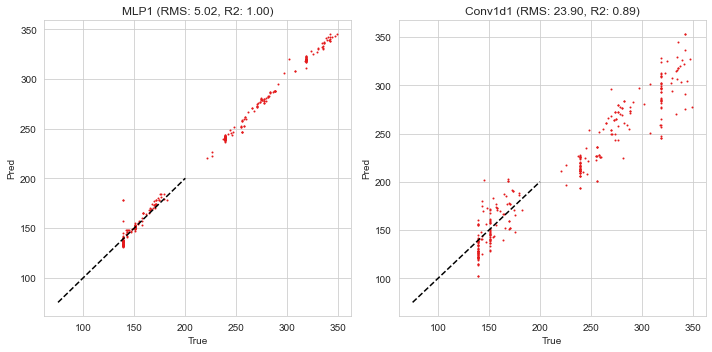

In [9]:
import numpy
import csv

test_loaderR = DataLoader(TensorDataset(dataR[2].unsqueeze(1), dataR[3]), batch_size=1, shuffle=True)

sns.set_style('whitegrid')
sns.set_palette('Set1')

fig, (ax1) = plt.subplots(1, 2, figsize=(10, 5))

y_pred_m, y_true_m, rms, r2 = model_infer(model_mlp, test_loaderR)
append_graph(ax1[0], y_true_m, y_pred_m, 'MLP1')
y_pred_c, y_true_c, rms, r2 = model_infer(model_conv, test_loaderR)
append_graph(ax1[1], y_true_c, y_pred_c, 'Conv1d1')


plt.tight_layout()
plt.show()

min_count = len(y_pred_m)


mlp_data = [['Concat', 'true', 'pred']]
for n in range(0, min_count):
    mlp_data.append(['', y_true_m[n], y_pred_m[n][0][0]])

f_mlp = open('result/mlp_concat_result.csv','w', newline='')
writer = csv.writer(f_mlp)
writer.writerows(mlp_data)
f_mlp.close()


conv_data = [['Concat', 'true', 'pred']]
for n in range(0, min_count):
    conv_data.append(['', y_true_c[n], y_pred_c[n][0]])

f_conv = open('result/conv_concat_result.csv','w', newline='')
writer = csv.writer(f_conv)
writer.writerows(conv_data)
f_conv.close()

In [10]:
data = (dataR[2].unsqueeze(1)).to("cuda")
result = model_mlp(data[0:5])
print(data[0:5])
print(result)

tensor([[[ 9.9462e-01,  9.8799e-01,  1.0477e+00, -9.5446e-01,  1.0405e+00,
           4.3057e-01,  6.0868e-01,  6.8426e-01, -7.2277e-01, -5.8215e-01,
           3.1013e-02, -7.4839e-01, -2.7510e-01, -8.7704e-01, -7.5250e-01,
          -5.2435e-01,  1.3626e-01]],

        [[ 1.1030e+00,  1.0964e+00,  1.0477e+00,  2.4584e-01,  1.1490e+00,
           1.3190e-02,  1.1474e+00,  6.5106e-01, -7.6346e-01, -3.7902e-01,
          -2.7018e-01, -7.6285e-01, -3.4602e-01,  2.4341e-01, -7.5750e-01,
          -2.9843e-01,  5.6913e-01]],

        [[ 9.9462e-01,  1.0964e+00,  1.0477e+00,  2.4584e-01,  9.3195e-01,
          -2.0699e+00, -1.1221e+00,  6.7772e-01, -7.4652e-01, -9.7242e-01,
          -2.0618e-01, -9.3720e-01, -6.1936e-01, -8.9920e-01, -6.9012e-01,
           5.4284e-01,  4.3443e-01]],

        [[-1.0447e+00, -9.4681e-01, -1.0087e+00,  2.4584e-01, -9.9737e-01,
           1.8855e-02,  1.3780e-01,  2.9968e-01,  1.3506e+00, -8.9038e-01,
           2.6056e-01,  2.2538e+00,  8.0584e-01,  1.7999e+